## Lower Body data analysis

Analysis of preprocessed lower body dataset

#### Define Imports and Settings
Defines imports and constants to tune analysis settings

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib.enums import TA_LEFT
from reportlab.lib import colors


# Input Dataset
DATA_PATH = "data/preprocessed/12.12_lowerBody.csv"

# Output Paths
FIG_PATH = "data/output/figures/12.12_step_freq.png"
PDF_PATH = "data/output/reports/12.12_report.pdf"



# VISUALIZATION SETTINGS
sns.set_theme(
    style="white",
    rc={
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": False,
        "legend.frameon": False,
})

# Strike Detection settings
MIN_STEP_TIME = 0.45  # seconds

# For Cadense and Step Frequencty
MIN_STEP = 0.20
MAX_STEP = 0.80
DEDUP_TIME = 0.10

#### Load preprocessed data
Loads Lower Body Preprocessed data

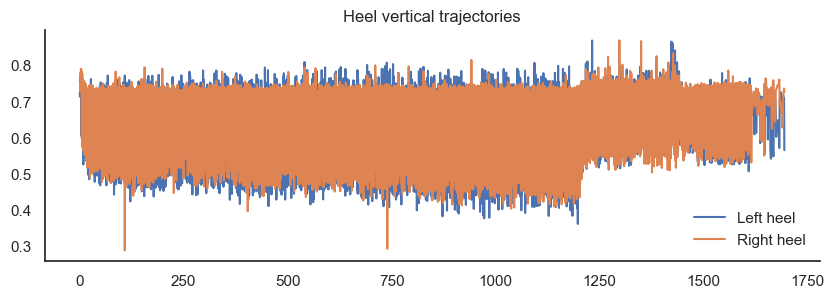

In [58]:
# Load Dataset
df = pd.read_csv(DATA_PATH)
t = df["time_s"].to_numpy()

# SELELCT JOINT
LEFT_HEEL  = "left_heel"
RIGHT_HEEL = "right_heel"

# EXTRACT
y_left  = df[f"{LEFT_HEEL}_y"].to_numpy()
y_right = df[f"{RIGHT_HEEL}_y"].to_numpy()

# Plot to check
plt.figure(figsize=(10,3))
plt.plot(t, y_left, label="Left heel")
plt.plot(t, y_right, label="Right heel")
plt.title("Heel vertical trajectories")
plt.legend()
plt.show()

#### Heel Strika Analysis
Analyses Heel Strike in each heel

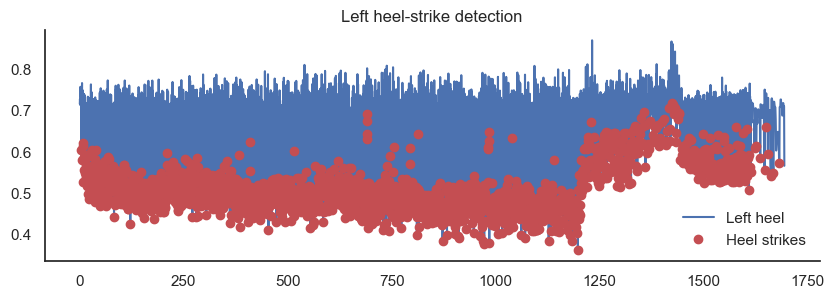

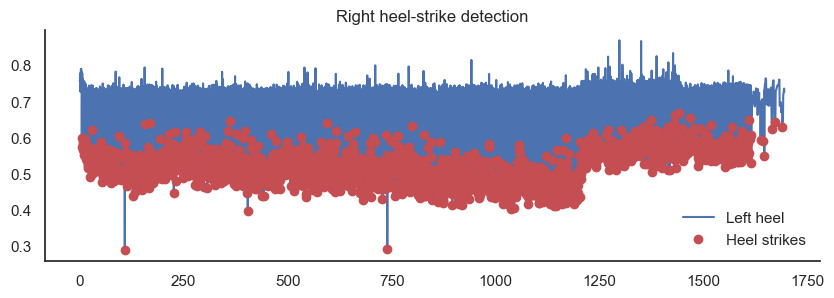

In [59]:
dt = np.median(np.diff(t))
fps = 1.0 / dt
min_dist_frames = int(MIN_STEP_TIME * fps)

peaks_L, _ = find_peaks(
    -y_left,
    distance=min_dist_frames,
    prominence=0.075
)

peaks_R, _ = find_peaks(
    -y_right,
    distance=min_dist_frames,
    prominence=0.075
)

plt.figure(figsize=(10,3))
plt.plot(t, y_left, label="Left heel")
plt.plot(t[peaks_L], y_left[peaks_L], "ro", label="Heel strikes")
plt.legend()
plt.title("Left heel-strike detection")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, y_right, label="Left heel")
plt.plot(t[peaks_R], y_right[peaks_R], "ro", label="Heel strikes")
plt.legend()
plt.title("Right heel-strike detection")
plt.show()

In [60]:
# FOOT-LEVEL STEP METRICS
def foot_summary(t, peaks, label):
    t_strikes = t[peaks]
    intervals = np.diff(t_strikes)
    intervals = intervals[(intervals >= MIN_STEP) & (intervals <= MAX_STEP)]

    return {
        "label": label,
        "num_strikes": len(t_strikes),
        "mean_step_time": np.mean(intervals),
        "std_step_time": np.std(intervals),
        "cadence_spm": 60.0 / np.mean(intervals),
    }

left = foot_summary(t, peaks_L, "Left")
right = foot_summary(t, peaks_R, "Right")
total_strikes = left["num_strikes"] + right["num_strikes"]

# SYMMETRY METRICS
sym_diff = abs(left["mean_step_time"] - right["mean_step_time"])
sym_ratio = left["mean_step_time"] / right["mean_step_time"]

# PRINT HUMAN-READABLE OUTPUT
print("\n========== FOOT-LEVEL GAIT QUALITY ==========")

print(f"\nTotal foot strikes (both feet): {total_strikes}")

for foot in (right, left):
    print(f"\n{foot['label']} foot:")
    print(f"  Heel strikes detected: {foot['num_strikes']}")
    print(f"  Mean step time:        {foot['mean_step_time']:.3f} s")
    print(f"  Cadence:               {foot['cadence_spm']:.1f} steps/min")

print("\nSYMMETRY:")
print(f"  Step-time difference: {sym_diff:.3f} s")
print(f"  Step-time ratio (L/R): {sym_ratio:.3f}")


========== FOOT-LEVEL GAIT QUALITY ==========

Total foot strikes (both feet): 4066

Right foot:
  Heel strikes detected: 2125
  Mean step time:        0.697 s
  Cadence:               86.1 steps/min

Left foot:
  Heel strikes detected: 1941
  Mean step time:        0.718 s
  Cadence:               83.6 steps/min

SYMMETRY:
  Step-time difference: 0.021 s
  Step-time ratio (L/R): 1.030


In [61]:
# COMBINE BOTH FEET INTO ONE STEP STREAM
t_steps = np.sort(np.concatenate([t[peaks_L], t[peaks_R]]))
dt = np.diff(t_steps, prepend=t_steps[0])
t_steps = t_steps[dt > DEDUP_TIME]

# STEP FREQUENCY OVER TIME
intervals = np.diff(t_steps)
valid = (intervals >= MIN_STEP) & (intervals <= MAX_STEP)

intervals = intervals[valid]
t_mid = t_steps[1:][valid]
step_freq = 1.0 / intervals   # Hz

# TREND (ONE NUMBER THAT MATTERS)
slope, intercept = np.polyfit(t_mid, step_freq, 1)
slope_per_min = slope * 60.0

# BINNED PLOT (HUMAN-READABLE)
bins = np.linspace(t_mid.min(), t_mid.max(), 25)
bin_id = np.digitize(t_mid, bins)

bin_t, bin_f = [], []
for i in range(1, len(bins)):
    m = bin_id == i
    if np.any(m):
        bin_t.append(t_mid[m].mean())
        bin_f.append(step_freq[m].mean())

plt.figure(figsize=(10,3))
plt.plot(bin_t, bin_f, "o-", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Step frequency (Hz)")
plt.title("Average step frequency over time")
plt.tight_layout()
plt.savefig(FIG_PATH, dpi=200, bbox_inches="tight")
plt.close()

# PRINT SIMPLE CONCLUSION
print("\n========== STEP FREQUENCY OVER TIME ==========")
print(f"Total steps analysed: {len(intervals)}")
print(f"Average step frequency: {np.mean(step_freq):.2f} Hz")
print(f"Change over time: {slope_per_min:+.3f} Hz per minute")


========== STEP FREQUENCY OVER TIME ==========
Total steps analysed: 3847
Average step frequency: 2.71 Hz
Change over time: -0.030 Hz per minute


#### Report Generation

In [62]:
# ============================================================
# DOCUMENT SETUP
# ============================================================

doc = SimpleDocTemplate(
    PDF_PATH,
    pagesize=A4,
    rightMargin=2*cm,
    leftMargin=2*cm,
    topMargin=2*cm,
    bottomMargin=2*cm,
)

styles = getSampleStyleSheet()

mono = ParagraphStyle(
    name="Mono",
    parent=styles["Normal"],
    fontName="Courier",
    fontSize=10,
    leading=12,
    alignment=TA_LEFT,
    textColor=colors.black,
)

title = ParagraphStyle(
    name="TitleMono",
    parent=mono,
    fontSize=12,
    leading=14,
)

story = []

# ============================================================
# HEADER
# ============================================================

story.append(Paragraph("GAIT ANALYSIS REPORT", title))
story.append(Spacer(1, 6))

story.append(Paragraph("Date: 12.12.2025", mono))
story.append(Paragraph("Acquisition: Treadmill running", mono))
story.append(Spacer(1, 12))

# ============================================================
# FOOT-LEVEL METRICS
# ============================================================

story.append(Paragraph("FOOT-LEVEL METRICS", title))
story.append(Spacer(1, 6))

story.append(Paragraph(f"Total foot strikes (L+R): {total_strikes}", mono))
story.append(Spacer(1, 6))

for foot in (right, left):
    story.append(Paragraph(f"{foot['label']} FOOT", mono))
    story.append(Paragraph(f"  Heel strikes:        {foot['num_strikes']}", mono))
    story.append(Paragraph(f"  Mean step time:      {foot['mean_step_time']:.3f} s", mono))
    story.append(Paragraph(f"  Step time STD:       {foot['std_step_time']:.3f} s", mono))
    story.append(Paragraph(f"  Cadence:             {foot['cadence_spm']:.1f} steps/min", mono))
    story.append(Spacer(1, 6))

# ============================================================
# SYMMETRY
# ============================================================

story.append(Paragraph("STEP SYMMETRY", title))
story.append(Spacer(1, 6))

story.append(Paragraph(f"Step-time difference:  {sym_diff:.3f} s", mono))
story.append(Paragraph(f"Step-time ratio (L/R): {sym_ratio:.3f}", mono))
story.append(Spacer(1, 12))

# ============================================================
# STEP FREQUENCY OVER TIME
# ============================================================

story.append(Paragraph("STEP FREQUENCY (COMBINED FEET)", title))
story.append(Spacer(1, 6))

story.append(Paragraph(f"Steps analysed:        {len(intervals)}", mono))
story.append(Paragraph(f"Mean frequency:        {np.mean(step_freq):.2f} Hz", mono))
story.append(Paragraph(f"Trend slope:           {slope_per_min:+.3f} Hz / min", mono))
story.append(Spacer(1, 12))

# ============================================================
# FIGURE
# ============================================================

story.append(Paragraph("STEP FREQUENCY TREND (TIME)", title))
story.append(Spacer(1, 6))

story.append(Image(FIG_PATH, width=16*cm, height=5*cm))

# ============================================================
# BUILD
# ============================================================

doc.build(story)

print(f"PDF report saved as: {PDF_PATH}")

PDF report saved as: data/output/reports/12.12_report.pdf
